
# Advanced Data Science Capstone

## Correlation of air pollution and Prevalence of Heart failures in Germany  

## Feature Creation and Feature engineering

### The deliverables
The deliverables of the current stage:

 - Pandas dataframe with disease prevalence column(s), county id, and some features extracted from air pollution data series for sensors located in corresponding county

###  Feature creation
The basic features for air pollution levels are

 - Number of hours when pollutant concentration exceeded some certain value
 - Mean or Median concentration of the pollutant
 
###  Feature quality check

 - Feature variance
 - Feature cross-correlation matrix
 
 First of all the necessary libraries and the datasets preprocessed at the ETL stage loaded:

In [316]:
# Libraries:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re


In [317]:
# Files:
SensorLocation = pd.read_csv('Capstone.ETL/Capstone.etl.SensorLocationCSV.1.0.csv')
dfHeart = pd.read_csv('Capstone.ETL/Capstone.etl.dfHeartCSV.1.0.csv')
dffAll = pd.read_csv('Capstone.ETL/Capstone.etl.wideCSV.1.0.gzip', compression='gzip', index_col=None)

###  Feature creation

Now let's create some basic features, illustrating some integral quantities of air pollution over the year.
For the start the following features will be generated:
 - Average concentration of every kind of pollutant over the year (average over all sensors within the county)
 - 75th percentile of every kind pollutant over the year, that is also proportional to the number of days when pollutant concentration exceeded some certain value

#### Mean pollutant concentration over the year
The quantity can be straightforward extracted using *.describe()* method of the dataframe:

In [336]:
dffAllSummary=dffAll.describe()

def MeanByPollutantCountyID(Pollutant, CountyID):
    PollutantMasc='^.{8}' + Pollutant + '_'
# collecting set of all sensors in the given county:    
    CountyStationSet = SensorLocation.loc[SensorLocation['countyid']==CountyID]['SensorID'].tolist()
    if CountyStationSet == []:
        return(np.nan)
    try:
        dffAllPollutantCountyID = dffAllSummary[[col for col in dffAllSummary.columns if re.search('(^.{7})',col).group(1) in CountyStationSet]].filter(regex=PollutantMasc,axis=1)
        return(dffAllPollutantCountyID.loc[['mean']].mean(axis=1))
    except:    
        return(np.nan)


In [337]:
ListOfPollutants = ['CO','NO','NO2','NOx','O3','PM1','PM2', 'PM10', 'SO2', 'CHB', 'CH4', 'C8H10', 'CHT', 'CO2']

for pollutant in ListOfPollutants:
    ColIndex=pollutant+'mean'
    dfHeart[ColIndex] =dfHeart.apply(lambda x: MeanByPollutantCountyID(pollutant, x['Regions-ID']), axis=1)

In [338]:
#dfHeart.head(53)
dfHeart.isna().sum()

Region          0
Regions-ID      0
KV              0
Kreistyp        0
Wert            0
Bundeswert      0
COmean        336
NOmean        187
NO2mean       186
NOxmean       213
O3mean        208
PM1mean       197
PM2mean       300
PM10mean      402
SO2mean       315
CHBmean       385
CH4mean       392
C8H10mean     399
CHTmean       385
CO2mean       396
dtype: int64

From the table above one can see, that only 5 pollutants (*NO, NO2, NOx, O3, PM1*) were measured in about a half of german counties (total number of counties mentioned in the *heart failures* dataset is 402). Let's take a look, in how many counties all 6 pollutants were measured simultaneously:

In [339]:
FeatureSetDenseMean = dfHeart[['Regions-ID','Wert','NOmean','NO2mean','NOxmean','O3mean','PM1mean']].dropna().reset_index(drop=True)
FeatureSetDenseMean.columns=['CountyID','HeartFailR','NOmean','NO2mean','NOxmean','O3mean','PM1mean']

In [340]:
FeatureSetDenseMean.describe()

,CountyID,HeartFailR,NOmean,NO2mean,NOxmean,O3mean,PM1mean
count,144.000000,144.000000,144.000000,144.000000,144.000000,144.000000,144.000000
mean,8910.180556,3.216597,10.451816,18.664292,33.863397,48.741819,16.313968
std,4487.436430,1.031290,10.155415,10.028704,25.147107,8.196358,3.277536
min,1003.000000,1.500000,0.289135,4.256108,2.356005,33.445765,7.480554
25%,5329.500000,2.545000,2.105451,9.795802,12.781112,43.053047,14.178934
50%,7314.500000,2.995000,6.319397,16.191621,26.157668,47.696601,16.410147
75%,13071.250000,3.632500,16.390253,26.398841,49.249128,52.295473,18.590476
max,16077.000000,6.160000,39.808819,42.477908,100.943063,71.032766,23.129197


From the table above one can conclude, that despite only about a third of german counties are included into the **FeatureSetDense** dataset, all the measured quantities have good variability. In order to illustrate it, the histograms are plotted:

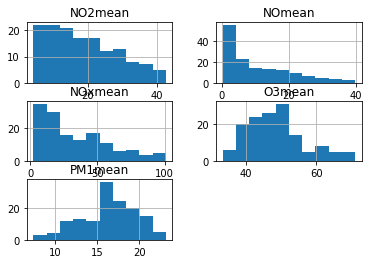

In [341]:
FeatureSetDenseMean.hist(column=['NOmean','NO2mean','NOxmean','O3mean','PM1mean']);

We can also maximize number of counties in the dataset, removing 2 of 5 pollutants. It is found, that for the current dataset it will lead to increase of observations up to 199, almost a half of the counties:

In [342]:
FeatureSetLongMean = dfHeart[['Regions-ID','Wert','NOmean','NO2mean','PM1mean']].dropna().reset_index(drop=True)
FeatureSetLongMean.columns=['CountyID','HeartFailR','NOmean','NO2mean','PM1mean']
FeatureSetLongMean.describe()

,CountyID,HeartFailR,NOmean,NO2mean,PM1mean
count,199.000000,199.000000,199.000000,199.000000,199.000000
mean,8718.924623,3.110101,13.009667,21.039965,16.777042
std,4126.990729,0.977749,12.702115,10.630969,3.299534
min,1001.000000,1.500000,0.289135,4.256108,7.480554
25%,5558.000000,2.470000,2.980229,12.436634,15.136554
50%,8211.000000,2.850000,9.598045,20.293349,16.868519
75%,12064.500000,3.480000,19.242869,28.149118,18.813398
max,16077.000000,6.160000,74.765378,56.669541,28.322063


#### Quantile-based features
Constructing the global distribution of selected pollutant concentration over all counties of interest,
one can find e.g. 75th quantile of this pollutant concentration distribution, 
and than count number of hours, when this concentration was exceeded in each county.
This quantity is some generalization of the *"number of days when the pollutant limit has been exceeded"* quantity, because it tune itself to pollution levels available in the dataset.

In [343]:
# Function for Croppind of initial dffAll dataset to columns reflecting measurements 
# of pollutants in ListOfPollutants at counties in ListOfCountyIDs:
def CropPollutantsIDsTS(ListOfPollutants, ListOfCountyIDs):
    CountyStationSet=[]
    dffAllCrop=pd.DataFrame(dffAll['observation_period'])

    for CountyID in ListOfCountyIDs:
        CountyStationSet.extend(SensorLocation.loc[SensorLocation['countyid']==CountyID]['SensorID'].tolist())
    for Pollutant in ListOfPollutants:
        PollutantMasc='^.{8}' + Pollutant + '_' 
        dffAllCrop=dffAllCrop.join(dffAll[[col for col in dffAll.columns if re.search('(^.{7})',col).group(1) in CountyStationSet]].filter(regex=PollutantMasc,axis=1))
    return(dffAllCrop)

# Function for calculating Nth percentiles for pollutants in ListOfPollutants at counties in ListOfCountyIDs:
def ReturnNthPercentilePollutantsIDsTS(Percentile, ListOfPollutants, ListOfCountyIDs):
    CountyStationSet=[]
    NthPercentile=pd.DataFrame()

    for CountyID in ListOfCountyIDs:
        CountyStationSet.extend(SensorLocation.loc[SensorLocation['countyid']==CountyID]['SensorID'].tolist())
    for Pollutant in ListOfPollutants:
        PollutantMasc='^.{8}' + Pollutant + '_'
        NthPercentile[Pollutant] = [(dffAll[[col for col in dffAll.columns if re.search('(^.{7})',col).group(1) in CountyStationSet]].filter(regex=PollutantMasc,axis=1)).stack().reset_index(drop=True).quantile(Percentile/100.0)]
    return(NthPercentile)

# Function for calculating Feature matrix, containing average (over sensors) number of hours for each county, when pollutant concentration
# was exceeding Nth global percentiles for the pollutant at counties of interest (in ListOfCountyIDs):
def FeatureMatrixNthPercentile(Percentile, ListOfPollutants, ListOfCountyIDs):
    NthPercentile=ReturnNthPercentilePollutantsIDsTS(Percentile, ListOfPollutants, ListOfCountyIDs)
    dffAllCrop=CropPollutantsIDsTS(ListOfPollutants, ListOfCountyIDs)

    FeatureMatrix=pd.DataFrame({'CountyID': dfHeart.loc[dfHeart['Regions-ID'].isin(ListOfCountyIDs)]['Regions-ID'], 'HeartFailR': dfHeart.loc[dfHeart['Regions-ID'].isin(ListOfCountyIDs)]['Wert']}).reset_index(drop=True)
    for Pollutant in ListOfPollutants:
        PollutantHoursExceed=[]
        PollutantMasc='^.{8}' + Pollutant + '_'
        for CountyID in ListOfCountyIDs:
            CountyStationSet=[]
            CountyStationSet.extend(SensorLocation.loc[SensorLocation['countyid']==CountyID]['SensorID'].tolist())

            dffPollutantCounty = dffAllCrop[[col for col in dffAllCrop.columns if re.search('(^.{7})',col).group(1) in CountyStationSet]].filter(regex=PollutantMasc,axis=1)
            NumPollutantStationsAtCounty = dffPollutantCounty.shape[1]
            PollutantHoursExceed.append((dffPollutantCounty.stack().reset_index(drop=True)>NthPercentile[Pollutant][0]).reset_index(drop=True).sum()/NumPollutantStationsAtCounty)
        FeatureMatrix = FeatureMatrix.reset_index(drop=True).join(pd.DataFrame({Pollutant : PollutantHoursExceed}))        
    return(FeatureMatrix)

The same way as it was done for the pollutant mean as a feature, the quantile-based features with two types of pollutant lists (*Dense* and *Long*) and two percentile values (50 and 75) will be created:

In [344]:
ListOfPollutantsDense = ['NO','NO2','NOx','O3','PM1']
ListOfCountyIDsDense = FeatureSetDenseMean['CountyID']
FeatureSetDensePerc50 = FeatureMatrixNthPercentile(50, ListOfPollutantsDense, ListOfCountyIDsDense)
FeatureSetDensePerc75 = FeatureMatrixNthPercentile(75, ListOfPollutantsDense, ListOfCountyIDsDense)

ListOfPollutantsLong = ['NO','NO2','PM1']
ListOfCountyIDsLong = FeatureSetLongMean['CountyID']
FeatureSetLongPerc50 = FeatureMatrixNthPercentile(50, ListOfPollutantsLong, ListOfCountyIDsLong)
FeatureSetLongPerc75 = FeatureMatrixNthPercentile(75, ListOfPollutantsLong, ListOfCountyIDsLong)

In [345]:
FeatureSetDensePerc50.tail(10)
#FeatureSetLongPerc50.tail(10)
#FeatureSetDensePerc75.tail(10)
#FeatureSetLongPerc75.tail(10)


,CountyID,HeartFailR,NO,NO2,NOx,O3,PM1
134,5711,1.90,6779.500000,6341.000000,6569.000000,3455.0,5881.500000
135,12051,1.85,4646.500000,4198.000000,4543.500000,4190.0,4853.000000
136,3402,1.80,3373.000000,3349.000000,3220.000000,4889.0,3906.000000
137,6414,1.77,7468.666667,7699.666667,7701.333333,2938.0,5276.000000
138,6412,1.77,7732.000000,7904.333333,7944.666667,2629.5,5378.666667
139,7315,1.68,6843.200000,7082.000000,7159.400000,3336.0,5267.333333
140,6411,1.64,6369.000000,6899.500000,6794.500000,2969.0,5316.000000
141,6433,1.63,4621.000000,5022.000000,4963.000000,3207.0,4583.500000
142,8315,1.63,2087.000000,2171.000000,39.000000,6394.5,2656.000000
143,7111,1.50,7703.500000,7765.500000,7849.500000,2300.0,4933.000000


###  Feature transformation

In this part the following notation is used:
 - *X, y* - features and labels of initial feature matrix.
 - *X_train0, X_test0, y_train0, y_test0* initial feature matrix, splitted into train and test sets
 - *X_train, X_test, y_train, y_test* normalized feature matrix, splitted into train and test sets
 - *X_train_XXX, X_test_XXX, y_train_XXX, y_test_XXX* transformed (XXX is the name of transformation) feature matrix, splitted into train and test sets
 

#### Normalization
For use in the machine-learning and especially deep learning frameworks the features have to be normalized:

In [359]:
FeatureSet = FeatureSetDensePerc50

#from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn import decomposition
from sklearn.preprocessing import PolynomialFeatures

X, y = FeatureSet.drop(['CountyID', 'HeartFailR'], axis=1), FeatureSet['HeartFailR']
X_train0, X_test0, y_train0, y_test0 = train_test_split(X, y, random_state=0)


# default scaler: maps to [0:1]
scaler = MinMaxScaler()

scaler.fit(X_train0)
# apply transform
X_train = scaler.transform(X_train0)
X_test  = scaler.transform(X_test0)

# inverse transform
inverse = scaler.inverse_transform(X_train)
# also, maybe lognorm-like distribution can be converted to ~normal with box-cox.

checking inversibility of the scaling procedure:

In [355]:
print(X_train0[0:4])
print(inverse[0:4])

         NO     NO2     NOx      O3     PM1
76   3299.0  3948.0  3934.0  3816.0  4450.0
105  3521.5  2385.0  2552.5  3900.0  4614.5
56   2943.0  2286.0  2410.5  4601.0  4760.0
108  4129.0  4364.0  4086.0  3585.0  4890.0
[[3299.  3948.  3934.  3816.  4450. ]
 [3521.5 2385.  2552.5 3900.  4614.5]
 [2943.  2286.  2410.5 4601.  4760. ]
 [4129.  4364.  4086.  3585.  4890. ]]


#### Principal Component Analysis (PCA)
The 5 features from the initial dataset are projected onto 3 eigenvectors, corresponding to 3 extreme eigenvalues of the feature matrix:

In [364]:
pca = decomposition.PCA(n_components=3)
pca.fit(X_train0)
print("PCA explained variance:", pca.explained_variance_ratio_)
X_train_PCA = pca.transform(X_train0)
X_test_PCA = pca.transform(X_test0)

PCA explained variance: [0.92668993 0.04759515 0.01215964]


#### Polynomial Features
In order to capture nonlinear behavior of the model,  one can extend the basis set from x<sub>1</sub>, x<sub>2</sub>, x<sub>3</sub> to 1, x<sub>1</sub>, x<sub>1</sub><sup>2</sup>, x<sub>2</sub>, x<sub>2</sub><sup>2</sup>, x<sub>3</sub>, x<sub>3</sub><sup>2</sup>:

In [365]:
FeatureSet = FeatureSetLongPerc50
X, y = FeatureSet.drop(['CountyID', 'HeartFailR'], axis=1), FeatureSet['HeartFailR']
X_train0, X_test0, y_train0, y_test0 = train_test_split(X, y, random_state=0)


poly = PolynomialFeatures(2)
poly.fit_transform(X_train0)
X_train_UpToSquares = poly.transform(X_train0)
X_test_UpToSquares = poly.transform(X_test0)

In order to treat potential interactions between the feature variables,  one can extend the basis set from x<sub>1</sub>, x<sub>2</sub>, x<sub>3</sub> to 1, x<sub>1</sub>, x<sub>2</sub>, x<sub>3</sub>, x<sup>1</sup>x<sub>2</sub>, x<sub>1</sub>x<sub>3</sub>, x<sub>2</sub>x<sub>3</sub>, x<sub>1</sub>x<sub>2</sub>x<sub>3</sub>:

In [366]:
poly = PolynomialFeatures(degree=3, interaction_only=True)
poly.fit_transform(X_train0)
X_train_UpToCube = poly.transform(X_train0)
X_test_UpToCube = poly.transform(X_test0)